In [1]:
import numpy as np
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint 
import tensorflow as tf
from matplotlib.pyplot import rc

In [2]:
FAST_RUN = True
IMG_WIDTH = 300
IMG_HEIGHT = 300
IMG_CHANNELS = 3
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

In [3]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

In [4]:
def crop_generator(batches, crop_length):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

### Preparing data

In [5]:
path_real = '/Users/name/data/data/train/real/'
filenames_real = os.listdir(path_real)
labels_real = []
for file in filenames_real:
    labels_real.append(0)

In [6]:
path_spoof = '/Users/name/data/data/train/spoof/'
filenames_spoof = os.listdir(path_spoof)
labels_spoof = []
for file in filenames_spoof:
    labels_spoof.append(1)

In [7]:
print(len(filenames_real), ',', len(labels_real))
print(len(filenames_spoof), ',', len(labels_spoof))
# imbalanced data

1223 , 1223
4246 , 4246


In [8]:
df_real = pd.DataFrame({
    'filename' : filenames_real,
    'label' : labels_real
})

df_spoof = pd.DataFrame({
    'filename' : filenames_spoof,
    'label' : labels_spoof
})


In [9]:
df_real_2 = df_real.copy()

In [10]:
df_real_triple = pd.concat([df_real, df_real_2, df_real_2], ignore_index=True)

In [11]:
df_real_triple

,filename,label
0,YOUTUBE_id40_s2_75.png,0
1,YOUTUBE_id76_s0_45.png,0
2,YOUTUBE_id80_s0_135.png,0
3,YOUTUBE_id40_s4_107.png,0
4,YOUTUBE_id102_s0_105.png,0
...,...,...
3664,YOUTUBE_id24_s0_135.png,0
3665,YOUTUBE_id76_s0_60.png,0
3666,YOUTUBE_id102_s0_120.png,0
3667,YOUTUBE_id67_s0_150.png,0


In [12]:
df = pd.concat([df_real_triple, df_spoof], ignore_index=True)

In [13]:
df

,filename,label
0,YOUTUBE_id40_s2_75.png,0
1,YOUTUBE_id76_s0_45.png,0
2,YOUTUBE_id80_s0_135.png,0
3,YOUTUBE_id40_s4_107.png,0
4,YOUTUBE_id102_s0_105.png,0
...,...,...
7910,YOUTUBE_IIYAMAXB_WIZARD1_id16_s0_105.png,1
7911,YOUTUBE_MBP1314_IPHONE8B_id33_s1_131.png,1
7912,YOUTUBE_IIYAMAXU_SMG955U_S1_id30_s0_129.png,1
7913,YOUTUBE_IIYAMAXB_SMG955U_id97_s0_97.png,1


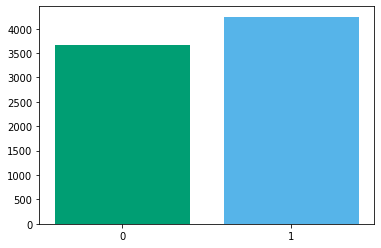

In [14]:
plt.bar('0', df['label'].value_counts()[0], color=("#009E73"))
plt.bar('1', df['label'].value_counts()[1], color=("#56B4E9"))
plt.show()

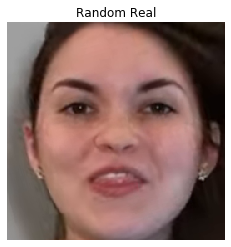

In [15]:
random_file = random.choice(filenames_real)
random_pic = load_img(path_real + random_file)
plt.imshow(random_pic)
plt.axis('off')
plt.title('Random Real')
plt.show()

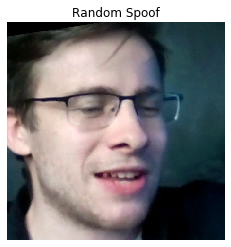

In [16]:
random_file = random.choice(filenames_spoof)
random_pic = load_img(path_spoof + random_file)
plt.imshow(random_pic)
plt.axis('off')
plt.title('Random Spoof')
plt.show()

### Callbacks

In [17]:
earlystop = EarlyStopping(patience=10)

In [18]:
lear_rate_reduc = ReduceLROnPlateau(monitor='val_loss',
                                    patience=3,
                                    verbose=1,
                                    factor=0.5,
                                    min_lr=0)

In [19]:
mpc_save = ModelCheckpoint('/Users/stanislav/model_eer.hdf5/', save_best_only=True, monitor='val_auc', mode='max')

In [20]:
callbacks = [earlystop, lear_rate_reduc, mpc_save]

### Preparing and looking at data

In [21]:
# for class_mode=binary/categorical labels must be string
df['label'] = df['label'].replace({0 : 'real', 1 : 'spoof'})

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.3, random_state=42)

In [23]:
len(train_df)

5540

In [24]:
train_df

,filename,label
7770,YOUTUBE_LG58020157_LP770_id37_s0_15.png,spoof
4015,YOUTUBE_IIYAMAXU_GZS4020_id16_s0_75.png,spoof
4635,YOUTUBE_IIYAMAXB_SMG955U_id85_s0_135.png,spoof
3779,YOUTUBE_NEC90GX2_ZC554KL_id33_s0_179.png,spoof
1611,FT720P_id2_s0_105.png,real
...,...,...
5226,YOUTUBE_IIYAMAXB_SMG955U_id108_s0_154.png,spoof
5390,YOUTUBE_S198150N_GM5_id36_s0_90.png,spoof
860,YOUTUBE_id114_s0_60.png,real
7603,YOUTUBE_IIYAMAXU_MOTOMC_S0_id44_s0_45.png,spoof


In [394]:
test_df = train_df.sample(frac=1)

In [395]:
train_df, test_df = test_df.iloc[0:4540], test_df.iloc[4540:5540]

In [396]:
train_df

,filename,label
2502,HUAWEIP7L_id122_s0_45.png,real
2823,YOUTUBE_id38_s0_45.png,real
6471,YOUTUBE_LGFUNKNOWN_SGS3GTI9300_id57_s1_45.png,spoof
1824,YOUTUBE_id99_s0_90.png,real
1116,YOUTUBE_id62_s0_142.png,real
...,...,...
2140,FT720P_id6_s0_105.png,real
3475,YOUTUBE_id113_s0_75.png,real
5760,YOUTUBE_MBA1315_SMG955U_S0_id61_s0_150.png,spoof
5658,YOUTUBE_SSM23B300_REDMIN4X_id47_s0_15.png,spoof


In [397]:
validate_df

,filename,label
4894,YOUTUBE_IIYAMAXB_IPHONE7F_id27_s0_45.png,spoof
7241,YOUTUBE_MBP1314_IPHONE8F_id57_s1_15.png,spoof
1677,YOUTUBE_id28_s0_136.png,real
1964,YOUTUBE_id32_s1_285.png,real
3025,YOUTUBE_id113_s0_30.png,real
...,...,...
2925,YOUTUBE_id69_s0_30.png,real
4619,YOUTUBE_IIYAMAXB_SMG955U_id50_s0_206.png,spoof
6868,YOUTUBE_LGE2360_LGK220DS_id36_s0_75.png,spoof
5728,YOUTUBE_PBLS11HR_HONOR9L_id33_s0_155.png,spoof


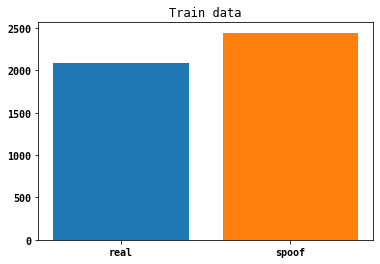

In [398]:
plt.bar('real', train_df[train_df.label == 'real'].label.value_counts())
plt.bar('spoof', train_df[train_df.label == 'spoof'].label.value_counts())
plt.title('Train data')
plt.show()

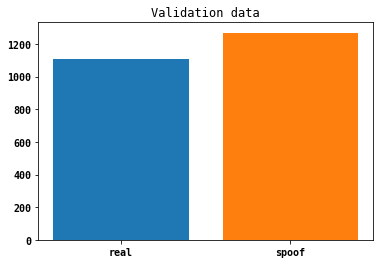

In [399]:
plt.bar('real', validate_df[validate_df.label == 'real'].label.value_counts())
plt.bar('spoof', validate_df[validate_df.label == 'spoof'].label.value_counts())
plt.title('Validation data')
plt.show()

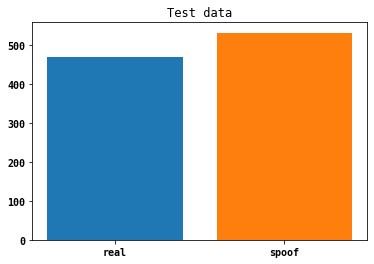

In [400]:
plt.bar('real', test_df[test_df.label == 'real'].label.value_counts())
plt.bar('spoof', test_df[test_df.label == 'spoof'].label.value_counts())
plt.title('Test data')
plt.show()

In [25]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 32

### Train generator

In [26]:
path_all = '/Users/stanislav/data/DSP/train/all/'

In [27]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )

In [28]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    path_all,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=IMG_SIZE,
                                                    class_mode='categorical',
                                                    batch_size=batch_size, 
                                                    shuffle=True)

Found 5540 validated image filenames belonging to 2 classes.


In [29]:
crop_train = crop_generator(train_generator, 128)

### Validation generator

In [30]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              path_all,
                                                              x_col='filename',
                                                              y_col='label',
                                                              target_size=IMG_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size,
                                                              shuffle=True)

Found 2373 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [32]:
crop_validation = crop_generator(validation_generator, 128)

### Building a model

In [33]:
model_pretrained = load_model('model_0210.h5')

In [106]:
base_layers = tf.keras.applications.Xception(input_shape=(128, 128, 3), weights='imagenet', include_top=False)
#base_layers.trainable = True
for layer in base_layers.layers[:-3]: 
    layer.trainable = True

In [107]:
model_pretrained = tf.keras.Sequential([
                             base_layers,
                             GlobalAveragePooling2D(),
                             Dense(512, activation='relu'),
                             Dropout(0.2),
                             Dense(2, activation='softmax')
])

In [108]:
model_pretrained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                         loss='categorical_crossentropy', 
                         metrics=tf.keras.metrics.AUC())

### Modeling

In [109]:
epochs=1 if FAST_RUN else 30
history = model_pretrained.fit(crop_train,
                      epochs=10,
                      validation_data=crop_validation,
                      validation_steps=total_validate // (batch_size),
                      steps_per_epoch=total_train // (batch_size),
                      callbacks=callbacks)

Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 0.3976 - auc: 0.9036WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/stanislav/model_eer.hdf5/assets
141/141 [==============================] - 1026s 7s/step - loss: 0.3976 - auc: 0.9036 - val_loss: 0.2910 - val_auc: 0.9615
Epoch 2/10
141/141 [==============================] - 1038s 7s/step - loss: 0.1855 - auc: 0.9790 - val_loss: 0.1104 - val_auc: 0.9912
Epoch 3/10
141/141 [==============================] - 1013s 7s/step - loss: 0.1311 - auc: 0.9887 - val_

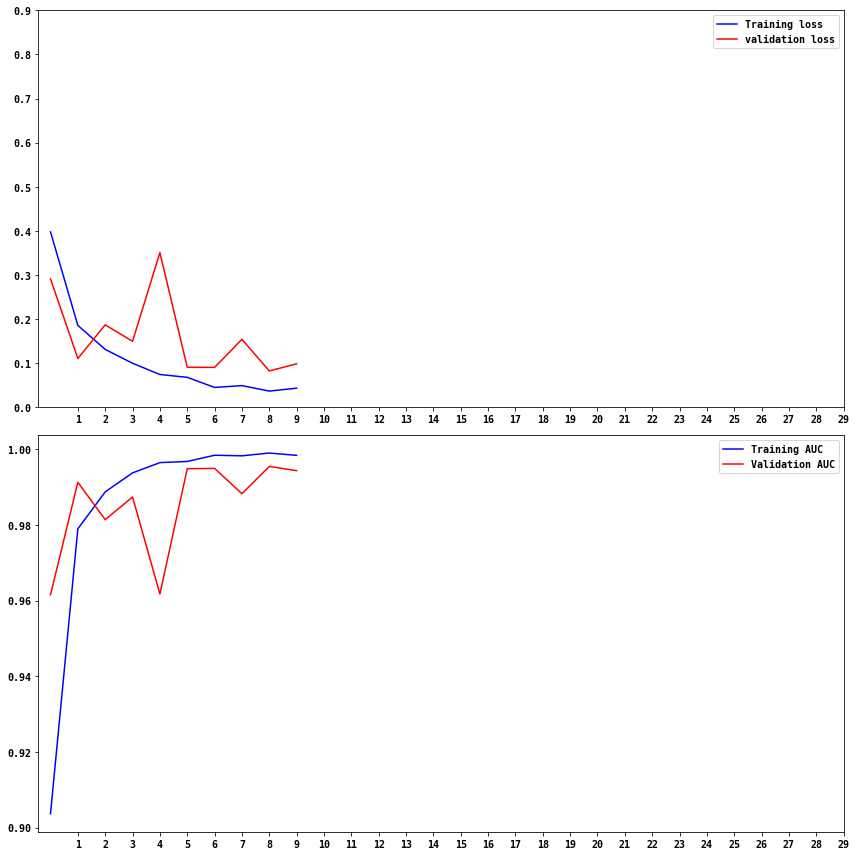

In [110]:
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size' : 10}
rc('font', **font)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['auc'], color='b', label="Training AUC")
ax2.plot(history.history['val_auc'], color='r',label="Validation AUC")
ax2.set_xticks(np.arange(1, 30, 1))

#legend = plt.legend(loc='best', shadow=True)
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.tight_layout()
plt.show()

In [467]:
model_pretrained.save('model_0210.h5')

### Testing

In [404]:
test_df = test_df.reset_index()

In [405]:
test_df

,index,filename,label
0,2160,YOUTUBE_id107_s0_135.png,real
1,3399,IPHONE8B_id4_s2_135.png,real
2,827,YOUTUBE_id28_s0_106.png,real
3,6352,YOUTUBE_MBP1314_IPHONE8B_id50_s0_105.png,spoof
4,1114,YOUTUBE_id87_s0_75.png,real
...,...,...,...
995,7249,YOUTUBE_IIYAMAXB_SMG955U_id110_s0_41.png,spoof
996,34,YOUTUBE_id38_s0_105.png,real
997,3371,YOUTUBE_id112_s0_15.png,real
998,7348,YOUTUBE_IIYAMAXU_MOTOMC_S0_id47_s0_60.png,spoof


In [40]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (128, 128, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

array([[0.52307856, 0.47692144]], dtype=float32)

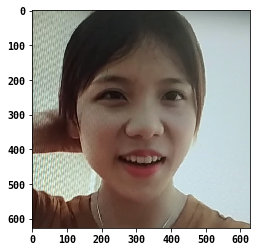

In [432]:
test_path = '/Users/name/data/data/train/all/'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
n=456
img = mpimg.imread(test_path + test_df['filename'][n])
imgplot = plt.imshow(img)
image = load(test_path + test_df['filename'][n])
model_pretrained.predict(image)

In [440]:
df_test = test_df.copy()

In [441]:
df_test['new'] = 0
df_test['new_2'] = 0
df_test['new_3'] = 0

In [442]:
df_test = df_test.drop('index', axis=1)

In [443]:
df_test.head()

,filename,label,new,new_2,new_3
0,YOUTUBE_id107_s0_135.png,real,0,0,0
1,IPHONE8B_id4_s2_135.png,real,0,0,0
2,YOUTUBE_id28_s0_106.png,real,0,0,0
3,YOUTUBE_MBP1314_IPHONE8B_id50_s0_105.png,spoof,0,0,0
4,YOUTUBE_id87_s0_75.png,real,0,0,0


In [444]:
train_path = '/Users/name/data/data/train/all/'
pd.options.mode.chained_assignment = None  # default='warn'

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (128, 128, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image
listik = []
for i in df_test['filename']:
    if '.png' in i:
        image = load(path_all + i)
        prediction = model_pretrained.predict(image)
        df_test.new[df_test.filename == i] = prediction[0][0]

In [445]:
for i in range(len(df_test['new'])):
    if df_test['new'].iloc[i] < 0.5:
        df_test['new_2'].iloc[i] += 1
    #else:
        #new_df['new_2'].iloc[i] == 0

In [446]:
for i in range(len(test_df['label'])):
    if df_test['label'].iloc[i] == 'spoof':
        df_test['new_3'].iloc[i] += 1
    #else:
        #new_df['new_2'].iloc[i] == 0

In [447]:
df_test

,filename,label,new,new_2,new_3
0,YOUTUBE_id107_s0_135.png,real,0.999743,0,0
1,IPHONE8B_id4_s2_135.png,real,0.999956,0,0
2,YOUTUBE_id28_s0_106.png,real,0.987170,0,0
3,YOUTUBE_MBP1314_IPHONE8B_id50_s0_105.png,spoof,0.138033,1,1
4,YOUTUBE_id87_s0_75.png,real,0.999949,0,0
...,...,...,...,...,...
995,YOUTUBE_IIYAMAXB_SMG955U_id110_s0_41.png,spoof,0.022290,1,1
996,YOUTUBE_id38_s0_105.png,real,0.999845,0,0
997,YOUTUBE_id112_s0_15.png,real,0.965562,0,0
998,YOUTUBE_IIYAMAXU_MOTOMC_S0_id47_s0_60.png,spoof,0.282619,1,1


In [415]:
df_test.new[(df_test.new > 0.51) & (df_test.new < 0.59)]

85     0.571829
90     0.577253
104    0.584239
185    0.544951
257    0.561851
259    0.528455
288    0.519646
381    0.516501
439    0.544951
456    0.523079
521    0.529937
549    0.529937
652    0.556836
665    0.577796
758    0.557027
828    0.551413
Name: new, dtype: float32

In [450]:
metrics.accuracy_score(y, pred)

0.95

### Preparing resluts on real test data

In [34]:
test_path = '/Users/name/data/data/test/test/'
test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({
    'filename' : test_filenames
})

In [35]:
for i in range(10001):
    if '.png' not in test_df.iloc[i,0]:
        print(i)

1545


In [36]:
test_df = test_df.drop([1545])

In [37]:
test_df

,filename
0,Y7U90OKU.png
1,IRUK1LQ8.png
2,LF0V6U5J.png
3,ITQBVH9Y.png
4,A8IR9P53.png
...,...
9996,7X7QIZA6.png
9997,QE6OU9R5.png
9998,RSUMISLS.png
9999,NYO9UEUM.png


In [38]:
nb_sample = test_df.shape[0] 
nb_sample

10000

array([[0.90830666, 0.09169339]], dtype=float32)

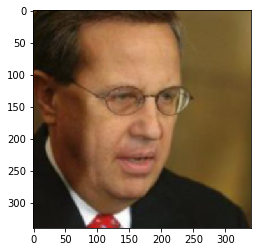

In [97]:
n=0
img = mpimg.imread(test_path + test_df['filename'][n])
imgplot = plt.imshow(img)
image = load(test_path + test_df['filename'][n])
model_pretrained.predict(image)

In [42]:
test_df['prob'] = 0

In [43]:
test_df

,filename,new
0,Y7U90OKU.png,0
1,IRUK1LQ8.png,0
2,LF0V6U5J.png,0
3,ITQBVH9Y.png,0
4,A8IR9P53.png,0
...,...,...
9996,7X7QIZA6.png,0
9997,QE6OU9R5.png,0
9998,RSUMISLS.png,0
9999,NYO9UEUM.png,0


In [46]:
pd.options.mode.chained_assignment = None  # default='warn'

def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (128, 128, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image
listik = []
for i in test_df['filename']:
    if '.png' in i:
        image = load(test_path + i)
        prediction = model_pretrained.predict(image)
        test_df['prob'][test_df['filename'] == i] = prediction[0][0]

In [94]:
test_df

,filename,new
0,Y7U90OKU.png,0.908307
1,IRUK1LQ8.png,1.000000
2,LF0V6U5J.png,0.675283
3,ITQBVH9Y.png,0.999956
4,A8IR9P53.png,0.565982
...,...,...
9996,7X7QIZA6.png,0.014173
9997,QE6OU9R5.png,0.001782
9998,RSUMISLS.png,0.609739
9999,NYO9UEUM.png,0.991169


In [95]:
test_df.to_csv('version_4_.csv', index=False)